# Visualizing cartographic variables to inform feature selection for predicting forest cover type

Part of the Prodigy Finance ComputeFest2017 competition: https://docs.google.com/forms/d/e/1FAIpQLScdiM0r_v6BTrbqjorZh8Ujd3Jgmps_jhR2tWW2Ya2A6Knz_A/viewform?c=0&w=1

Original data and description can be found at: https://archive.ics.uci.edu/ml/datasets/Covertype

# Import packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Local functions 

In [3]:
def reverse_dummy(df, col_name, col_list):
    '''
    Takes a df, a column name and a list of dummy variable column names as arguments.
    Combines dummy variables into a single column and drops dummy variable columns.
    Returns df.
    '''
    df[col_name] = ''
    for i in col_list:
        df[col_name] = np.where(df[i] == 1, i, df[col_name])
    df = df.drop(col_list, axis = 1)
    
    #convert strings to numeric
    num_list = list(range(1, len(col_list) + 1))
    for num in num_list:
        df[col_name] = df[col_name].replace((col_name + str(num)), num)
    return df

def plot_violin(y, data, x = 'cover_type'):
    '''
    Creates a violinplot of y vs. x (default cover_type)
    '''
    return sns.violinplot(x = x, y = y, data = data, hue = y, palette = 'Set2',
                          scale = 'count', inner = 'quartile', scale_hue = False)

def scale_columns(series):
    '''Uses sklearn's scale function to standardize all data in a df
    column (a pandas Series object) to zero mean and unit variance'''
    scaled = scale(np.array(series))
    return scaled

# Load raw data 

In [4]:
raw_file = pd.read_csv('covtype.data.gz', compression = 'gzip', header = None)

In [5]:
pd.set_option('display.max_columns', 100)
raw_file.head()

0    1   2    3    4     5    6    7    8     9   10  11  12  13  14  15  \
0  2596   51   3  258    0   510  221  232  148  6279   1   0   0   0   0   0   
1  2590   56   2  212   -6   390  220  235  151  6225   1   0   0   0   0   0   
2  2804  139   9  268   65  3180  234  238  135  6121   1   0   0   0   0   0   
3  2785  155  18  242  118  3090  238  238  122  6211   1   0   0   0   0   0   
4  2595   45   2  153   -1   391  220  234  150  6172   1   0   0   0   0   0   

   16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   

   54  
0   5  
1   5  
2   2  
3   2  
4   5

The column names are missing in the raw file. Kaggle provides a smaller data set ('train.csv') with the column names at https://www.kaggle.com/c/forest-cover-type-prediction/data

In [6]:
#get column names from 'train.csv'
cols_file = pd.read_csv('train.csv')
cols_file.columns

#'train_csv' has an extra column 'Id' that is not in the raw file
#remove 'Id'
cols_file = cols_file.drop('Id', axis = 1)
col_names = cols_file.columns.str.lower()

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

In [7]:
raw_file.columns = col_names
raw_file.head()

elevation  aspect  slope  horizontal_distance_to_hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   vertical_distance_to_hydrology  horizontal_distance_to_roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   hillshade_9am  hillshade_noon  hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   horizontal_distance_to_fire_points  wilderness_area1  wilderness_area2  \
0                                6279                 1                 0   
1                                6225                 1                 0   
2                                6121                 1                 0   
3                                6211                 1                 0   
4                                6172                 1                 0   

   wilderness_area3  wilderness_area4  soil_type1  soil_type2  soil_type3  \
0                 0                 0           0           0           0   
1                 0                 0           0           0           0   
2                 0                 0           0           0           0   
3                 0                 0           0           0           0   
4                 0                 0           0           0           0   

   soil_type4  soil_type5  soil_type6  soil_type7  soil_type8  soil_type9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   soil_type10  soil_type11  soil_type12  soil_type13  soil_type14  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            1            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   soil_type15  soil_type16  soil_type17  soil_type18  soil_type19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   soil_type20  soil_type21  soil_type22  soil_type23  soil_type24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   soil_type25  soil_type26  soil_type27  soil_type28  soil_type29  \
0            0            0            0            0            1   
1            0            0            0            0            1   
2            0        

There are two categorical variables (wilderness_area and soil_type) that are already one-hot-encoded. To perform exploratory data visualization it will be easier to reverse the one-hot-encoding.

In [8]:
#create lists of dummy variable column names
wild_area = list(raw_file.columns[10:14])
soil_type = list(raw_file.columns[14:54])

#make copy to keep raw_file, will need dummy variables later
features = raw_file.copy()
features = reverse_dummy(features, 'wilderness_area', wild_area)
features = reverse_dummy(features, 'soil_type', soil_type)

#shorten column names
short_names = ['elevation aspect slope h_dist_hydro v_dist_hydro dist_road shade_9 shade_12 shade_3 dist_fire cover_type area soil'.split()]
features.columns = short_names
features.head()

elevation  aspect  slope  h_dist_hydro  v_dist_hydro  dist_road  shade_9  \
0       2596      51      3           258             0        510      221   
1       2590      56      2           212            -6        390      220   
2       2804     139      9           268            65       3180      234   
3       2785     155     18           242           118       3090      238   
4       2595      45      2           153            -1        391      220   

   shade_12  shade_3  dist_fire  cover_type  area  soil  
0       232      148       6279           5     1    29  
1       235      151       6225           5     1    29  
2       238      135       6121           2     1    12  
3       238      122       6211           2     1    30  
4       234      150       6172           5     1    29

# Data exploration 

First, let's examine the class distributions of our ouputs, cover_type.

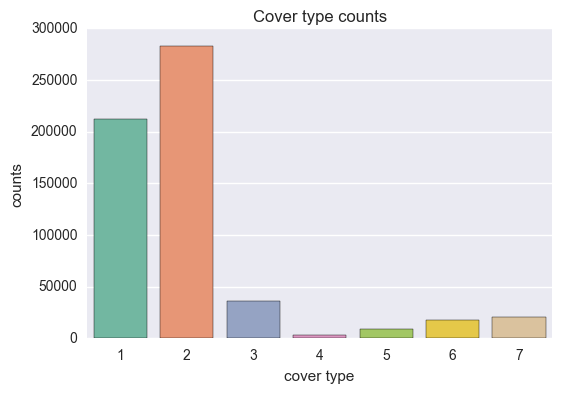

In [9]:
counts = pd.DataFrame()
counts['raw'] = features['cover_type'].value_counts()
counts['percent'] = counts['raw'] / features['cover_type'].count()
counts['cover_type'] = counts.index.values
p = sns.barplot(x = 'cover_type', y = 'raw', data = counts, palette = 'Set2');
p.set(xlabel = 'cover type', ylabel = 'counts', title = 'Cover type counts');

There is a very clear imbalance between the seven classes.

In [10]:
y = features['cover_type']
X = features
_, _, _, to_plot = train_test_split(X, y, test_size = 1/50, stratify = y)

features_plot = features[features.index.isin(to_plot.index)]

# Visualizing feature correlations

Generally

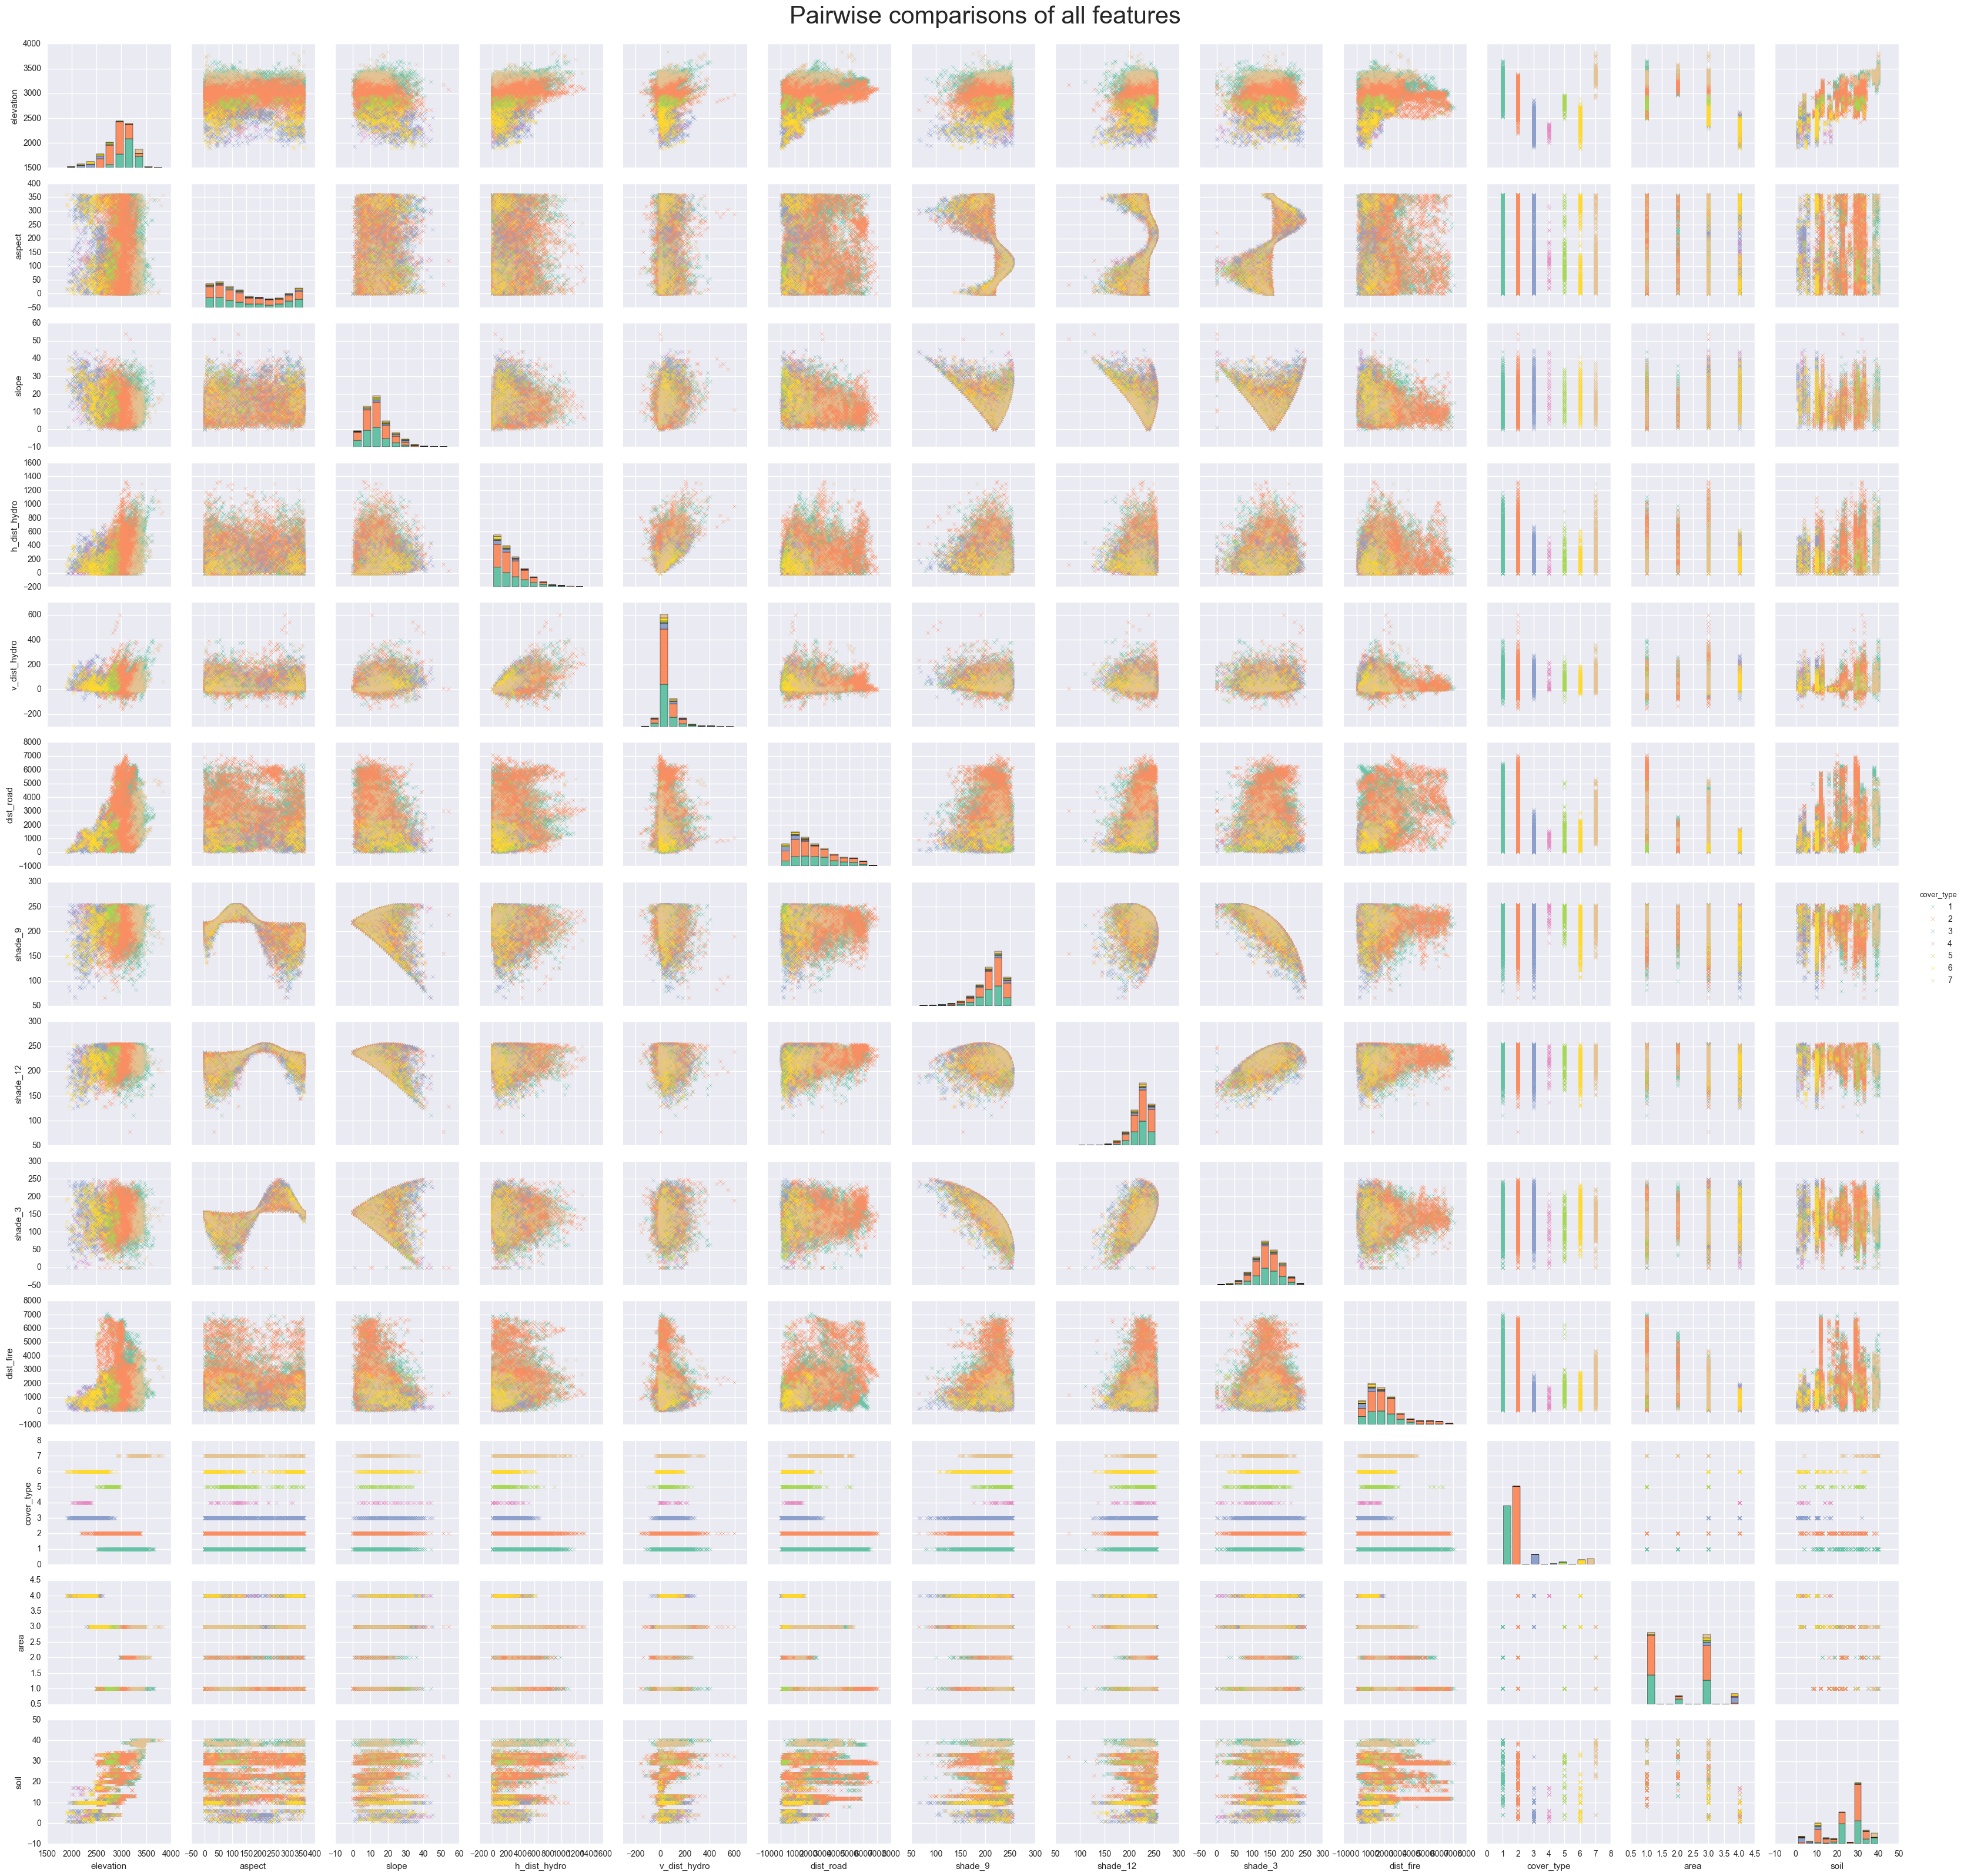

In [11]:
f = sns.pairplot(features_plot, hue = 'cover_type', markers = 'x', palette = 'Set2')
f.fig.suptitle('Pairwise comparisons of all features', verticalalignment = 'top', fontsize = 30);
f.fig.subplots_adjust(top = 0.96);

Outputting the file allows more in-depth exploration of figure f.

In [12]:
f.savefig('pairplot.png')

From figure f we note several things:
* Several features are correlated, indicating dimensionality reduction could be useful; however, many correlations are not simple linear ones.

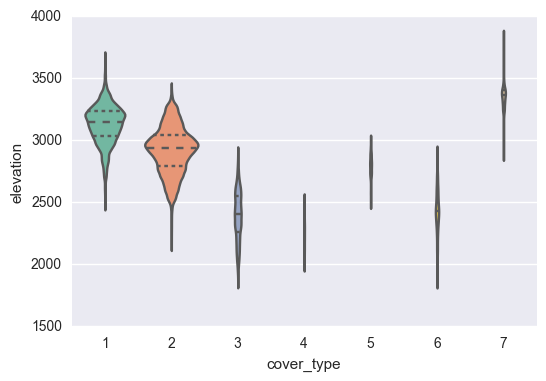

In [13]:
plot_violin('elevation', data = features);

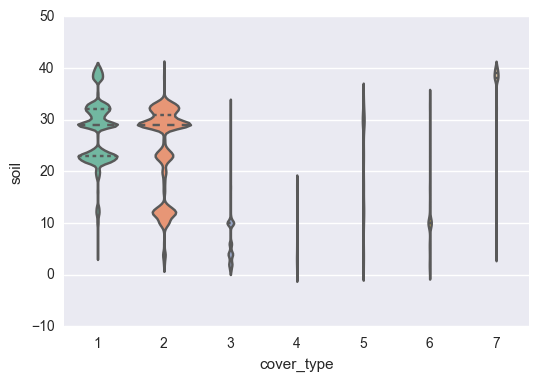

In [14]:
plot_violin('soil', data = features);

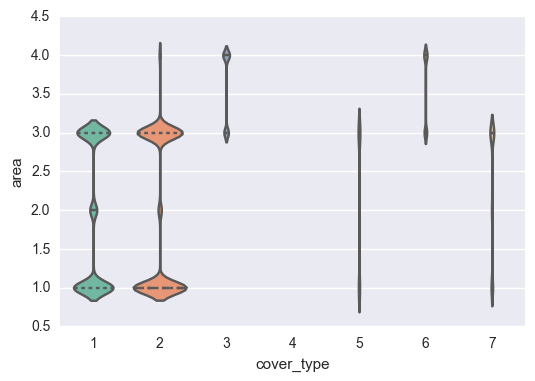

In [15]:
plot_violin('area', data = features);

# Dimensionality reduction 

Not a large set of features, but could still aid visualization

In [8]:
scaled_features = raw_file.iloc[:, :-1].apply(scale_columns)
scaled_features.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


elevation    aspect     slope  horizontal_distance_to_hydrology  \
0  -1.297805 -0.935157 -1.482820                         -0.053767   
1  -1.319235 -0.890480 -1.616363                         -0.270188   
2  -0.554907 -0.148836 -0.681563                         -0.006719   
3  -0.622768 -0.005869  0.520322                         -0.129044   
4  -1.301377 -0.988770 -1.616363                         -0.547771   

   vertical_distance_to_hydrology  horizontal_distance_to_roadways  \
0                       -0.796273                        -1.180146   
1                       -0.899197                        -1.257106   
2                        0.318742                         0.532212   
3                        1.227908                         0.474492   
4                       -0.813427                        -1.256464   

   hillshade_9am  hillshade_noon  hillshade_3pm  \
0       0.330743        0.439143       0.142960   
1       0.293388        0.590899       0.221342   
2       0.816364        0.742654      -0.196691   
3       0.965786        0.742654      -0.536343   
4       0.293388        0.540313       0.195215   

   horizontal_distance_to_fire_points  wilderness_area1  wilderness_area2  \
0                            3.246283           1.10808         -0.232859   
1                            3.205504           1.10808         -0.232859   
2                            3.126965           1.10808         -0.232859   
3                            3.194931           1.10808         -0.232859   
4                            3.165479           1.10808         -0.232859   

   wilderness_area3  wilderness_area4  soil_type1  soil_type2  soil_type3  \
0         -0.879364         -0.260673   -0.072416   -0.114549   -0.091491   
1         -0.879364         -0.260673   -0.072416   -0.114549   -0.091491   
2         -0.879364         -0.260673   -0.072416   -0.114549   -0.091491   
3         -0.879364         -0.260673   -0.072416   -0.114549   -0.091491   
4         -0.879364         -0.260673   -0.072416   -0.114549   -0.091491   

   soil_type4  soil_type5  soil_type6  soil_type7  soil_type8  soil_type9  \
0   -0.147649     -0.0525   -0.106986   -0.013444   -0.017555   -0.044475   
1   -0.147649     -0.0525   -0.106986   -0.013444   -0.017555   -0.044475   
2   -0.147649     -0.0525   -0.106986   -0.013444   -0.017555   -0.044475   
3   -0.147649     -0.0525   -0.106986   -0.013444   -0.017555   -0.044475   
4   -0.147649     -0.0525   -0.106986   -0.013444   -0.017555   -0.044475   

   soil_type10  soil_type11  soil_type12  soil_type13  soil_type14  \
0    -0.243947    -0.147734    -0.233216    -0.175866    -0.032125   
1    -0.243947    -0.147734    -0.233216    -0.175866    -0.032125   
2    -0.243947    -0.147734     4.287867    -0.175866    -0.032125   
3    -0.243947    -0.147734    -0.233216    -0.175866    -0.032125   
4    -0.243947    -0.147734    -0.233216    -0.175866    -0.032125   

   soil_type15  soil_type16  soil_type17  soil_type18  soil_type19  \
0    -0.002272    -0.070148    -0.076972    -0.057264     -0.08348   
1    -0.002272    -0.070148    -0.076972    -0.057264     -0.08348   
2    -0.002272    -0.070148    -0.076972    -0.057264     -0.08348   
3    -0.002272    -0.070148    -0.076972    -0.057264     -0.08348   
4    -0.002272    -0.070148    -0.076972    -0.057264     -0.08348   

   soil_type20  soil_type21  soil_type22  soil_type23  soil_type24  \
0    -0.127256    -0.038005     -0.24686    -0.332219    -0.194973   
1    -0.127256    -0.038005     -0.24686    -0.332219    -0.194973   
2    -0.127256    -0.038005     -0.24686    -0.332219    -0.194973   
3    -0.127256    -0.038005     -0.24686    -0.332219    -0.194973   
4    -0.127256    -0.038005     -0.24686    -0.332219    -0.194973   

   soil_type25  soil_type26  soil_type27  soil_type28  soil_type29  \
0    -0.028574    -0.066903    -0.043274    -0.040384     2.010336   
1    -0.028574    -0.066903    -0.043274    -0.040384     2.01

In [ ]:
num_comp = 20
pca = PCA(n_components = num_comp)
pca_fit = pca.fit(scaled_features)
reduced = pca.fit_transform(scaled_features)

pd.Series(pca_fit.explained_variance_ratio_.cumsum()).plot(kind = 'line', figsize = (10,3));
print('{:.2%}'.format(pca_fit.explained_variance_ratio_.cumsum()[-1]) + ' of the variance is explained by the first ' + str(num_comp) + ' components')

In [ ]:
#model = TSNE()
#tsne_fit = model.fit_transform(scaled_features)

In [ ]:
#add title
#g = sns.lmplot('dimension 1', 'dimension 2', tsne_fit, fit_reg=False, 
#               size=8,scatter_kws={'alpha':0.7,'s':60})

In [ ]:
#add title
#tsne_fit['cover'] = raw_file['cover_type']
#h = sns.lmplot('dimension 1', 'dimension 2', tsne_fit, hue = 'cover', fit_reg=False, 
#               size=8,scatter_kws={'alpha':0.7,'s':60})